In [2]:
# To import functions from Phase_1.py and Phase_2.py
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

from Phase_1 import Phase1Pipeline, load_model_from_path
from Phase_2 import Phase2Pipeline


Problem structure (as given in the email)

**Regression model (time to next failure prediction)**
- Predict the time in cycles remaining until the next degradation stage (eg: from s1 to s2)
- models to use: **Random forest regressor**, **Ridge regression**, **SVR**, etc

Tips:
- Add an extra column that contains the number of cycles to the next phase
    - NOTE to self: the stage labels are noisy, so find a way to somehow reduce that noise
    - This noise occurs when the engine is changing stage(s) only.
- Evaluate using standard regession metrics like: **RMSE**, **MAE**, **R^2**

**My approach**
1. Load and preprocess data
    - [ ] Load into a master df
    - [ ] Create train-test splits (shuffle = False | the problem's temporal)
    - [ ] Filter training data, reduce the noise during stage-shift
    - [ ] Create new column in training data with the time (cycles) to next stage
        - [ ] This new column is the `y` data for training (this is what we want the model to pred)
2. EDA
    - [ ] Check which featuers are important
    - [ ] Feature scaling issues and allat
    - [ ] Drop features with near to no change in values
    - [ ] Compare time to next stage vs sensor measurement
        - Is there a sudden change in sensor measurement or is it gradual
        - If there is a change, then how can you model that
3. Start modeling ig
    - [ ] Random-forest regressor
    - [ ] Ridge regression (l1/l2 try em all)
    - [ ] SVR
    - [ ] Locally weighted linear regression (normal lin-reg wont work)
    - [ ] See what works best and try to move on from that


**ChatGPT helped me improve my apprach and POA, so here it is:**
1. Load and preprocess data
    - [ ] Load master dataframe from Phase-1
    - [ ] Select engines for train/test (ensure no leakage)
        - Use temporal split, i.e. engines 1-80 in train and 81-100 in test
    - [ ] Retain the useful columns from Phase-2
    - [ ] Add flag for stage change cycle per engine. Binary column: `is_transition = True`
    - [ ] Add a new target: `cycles_to_next_stage`
    - [ ] If no stage change exists (i.e. in last stage-4), then `-1`
    - [ ] Filter out samples that are too close to a transition, where label noise is high
    - [ ] Decide whether to train only within stages 0-3 (since 4 has no 'next')
2. Feature engineering
    - [ ] Drop flat/noisy sensors (based on Phase-2)
    - [ ] Normalize (or) Standardize sensor values
    - [ ] Add rolling stats (mean, std, min, max, slope) for each sensor over last N cycles.
        - Trying to capture as many of the temporal trends as possible
3. EDA
    - [ ] Viz the distribution of `cycles_to_next_stage`
    - [ ] Correlate sensor values vs `cycles_to_next_stage`
    - [ ] Plot moving averages of sensors neat transitions (do values shift before stage-change)
4. Modeling
    - [ ] Random forest regressor
    - [ ] Ridge regression
    - [ ] Lasso regression
    - [ ] SVR
    - [ ] Try gradient boosting regressor
    - [ ] Locally weighted regression
5. Evaluate
    - [ ] RMSE
    - [ ] MAE
    - [ ] $R^2$
    - [ ] Use cross validation for the same metrics
6. Post analysis
    - [ ] Viz actual vs predicted plots
    - [ ] Analyse worst predictions (large errors)
    - [ ] [EXTRA] Fearture importance per model
    - [ ] [EXTRA] Retain top-k features

**Approach refined**
1. Load and preprocess data
    - [ ] Load into a master df
    - [ ] Add `time_to_next_stage` label
    - [ ] Mask samples around stage transitions ($\pm3$ cycles)
    - [ ] Add lag features (trend info)
2. EDA
    - [ ] Sensor vs `time_to_next_stage` plots
    - [ ] Drop near constant features
    - [ ] Compare time to next stage vs sensor measurement
        - Is there a sudden change in sensor measurement or is it gradual
        - If there is a change, then how can you model that
3. Start modeling ig
    - [ ] Random-forest regressor
    - [ ] Ridge regression (l1/l2 try em all)
    - [ ] SVR
    - [ ] Locally weighted linear regression (normal lin-reg wont work)
    - [ ] Train seperate regressors
        - One for predicting time from Stage 0 to 1
        - One for predicting time from Stage 1 to 2
        - So on
4. Visualization
    - [ ] Pred vs actual curves
    - [ ] Error distribution per transition

# Load and preprocess data
- Load into a master df
- Add `time_to_next_stage` label
- Mask samples around stage transitions ($\pm3$ cycles)
- Add lag features (trend info)

In [10]:
# Load data
import os
import pandas as pd
curr_dir = Path(os.getcwd())
data_dir = curr_dir.parent / "Phase_1" / "train_FD001_phase_1.csv"
df = pd.read_csv(data_dir)
df.head()

,Engine no,Num cycles,Operating 1,Operating 2,Operating 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,Sensor 10,Sensor 11,Sensor 12,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Stage
0,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,0
1,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,0
2,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,0
3,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,0
4,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,21.61,554.67,2388.02,9049.68,1.3,47.16,521.68,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669,0


In [26]:
# Add the `time_to_next_stage` column
import numpy as np

def compute_time_to_next_stage(df, window=3):
    result = []
    engines = df["Engine no"].unique()
    
    for engine in engines:
        sub_df = df[df["Engine no"] == engine].copy()
        stages = sub_df["Stage"].to_numpy()
        cycles = sub_df["Num cycles"].to_numpy()
        n = len(stages)
        y = [-1] * n

        for i in reversed(range(n-1)):
            if stages[i] != stages[i+1]:
                y[i] = 1
            elif y[i+1] != -1:
                y[i] = y[i+1] + 1

        clean_mask = [True] * n
        for i in range(1, n):
            if stages[i] != stages[i-1]:
                for j in range(max(0, i - window), min(n, i + window + 1)):
                    clean_mask[j] = False
        
        for i in range(n):
            result.append(y[i] if clean_mask[i] else np.nan)
    return result

df_clean = df.copy()
df_clean["time_to_next_stage"] = compute_time_to_next_stage(df_clean, window=1)
df_clean.head()

,Engine no,Num cycles,Operating 1,Operating 2,Operating 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,Sensor 10,Sensor 11,Sensor 12,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Stage,time_to_next_stage
0,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,0,13.0
1,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,0,12.0
2,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,0,11.0
3,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,0,10.0
4,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,21.61,554.67,2388.02,9049.68,1.3,47.16,521.68,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669,0,9.0


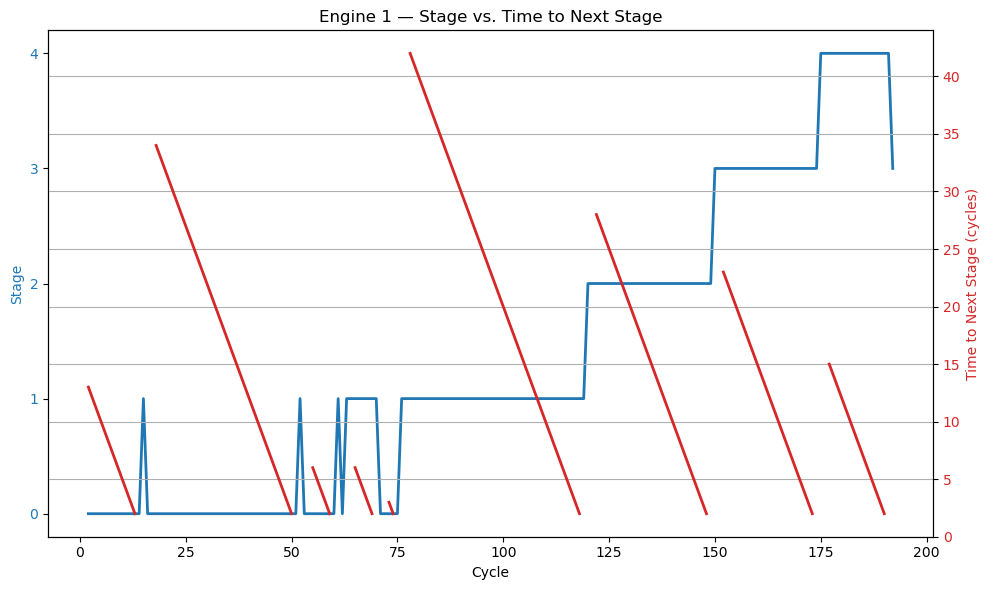

In [27]:
# Plot 'time_to_next_stage' for some of the engines
import matplotlib.pyplot as plt

def plot_time_to_next_stage(df, engine_no: int):
    engine_df = df[df["Engine no"] == engine_no]
    cycles = engine_df["Num cycles"]
    stages = engine_df["Stage"]
    times = engine_df["time_to_next_stage"]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Primary Y-axis for Stages
    ax1.plot(cycles, stages, color="tab:blue", label="Stage", linewidth=2)
    ax1.set_xlabel("Cycle")
    ax1.set_ylabel("Stage", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.set_yticks(sorted(df["Stage"].unique()))

    # Secondary Y-axis for time to next stage
    ax2 = ax1.twinx()
    ax2.plot(cycles, times, color="tab:red", label="Time to Next Stage", linewidth=2)
    ax2.set_ylabel("Time to Next Stage (cycles)", color="tab:red")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    # Title and grid
    plt.title(f"Engine {engine_no} — Stage vs. Time to Next Stage")
    fig.tight_layout()
    plt.grid(True)
    plt.show()

plot_time_to_next_stage(df_clean, 1)

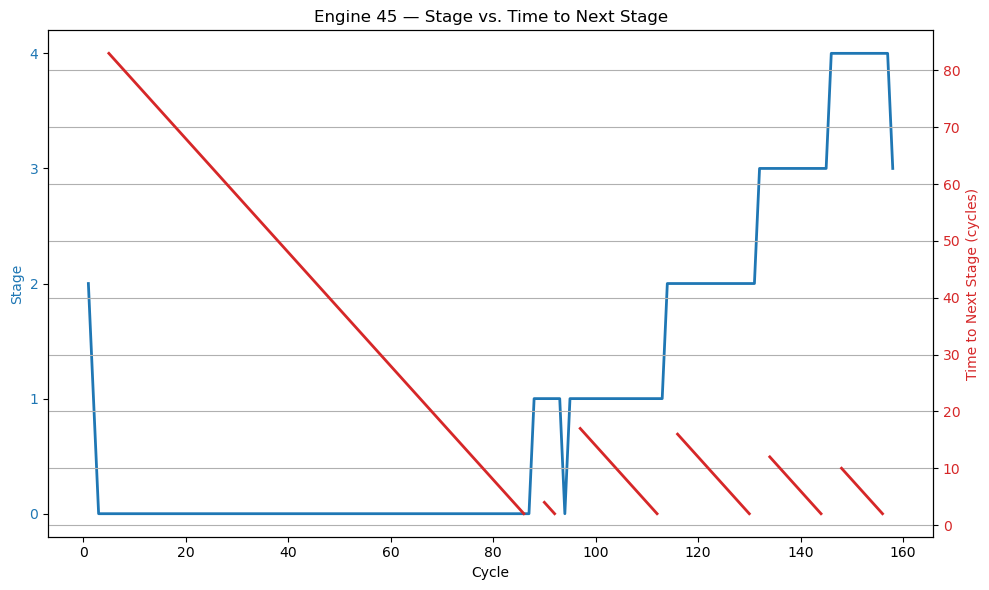

In [28]:
plot_time_to_next_stage(df_clean, 45)

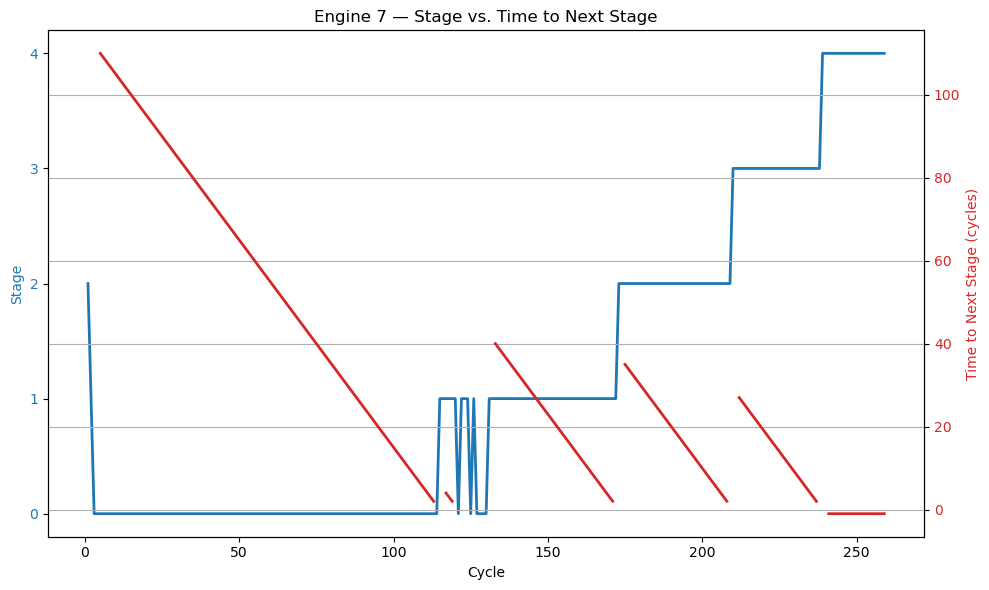

In [29]:
plot_time_to_next_stage(df_clean, 7)

There seem to be many outliers from the class labels, lets try to remove them.

In [60]:
# Clipping the start and end of a engine-stage
def trim_stage_outliers(df, trim_window=5):
    clean_indices = []
    for eng in df["Engine no"].unique():
        eng_df = df[df["Engine no"] == eng]
        stages = eng_df["Stage"].to_numpy()
        idxs = eng_df.index.to_numpy()

        # Check beginning
        head = stages[:trim_window]
        head_mode = np.bincount(head).argmax()
        for i in range(trim_window):
            if stages[i] == head_mode:
                clean_indices.append(idxs[i])

        # Middle part (trusted)
        clean_indices.extend(idxs[trim_window:-trim_window])

        # Check end
        tail = stages[-trim_window:]
        tail_mode = np.bincount(tail).argmax()
        for i in range(-trim_window, 0):
            if stages[i] == tail_mode:
                clean_indices.append(idxs[i])

    return df.loc[sorted(set(clean_indices))].reset_index(drop=True)

temp_df = trim_stage_outliers(df_clean, trim_window=5)

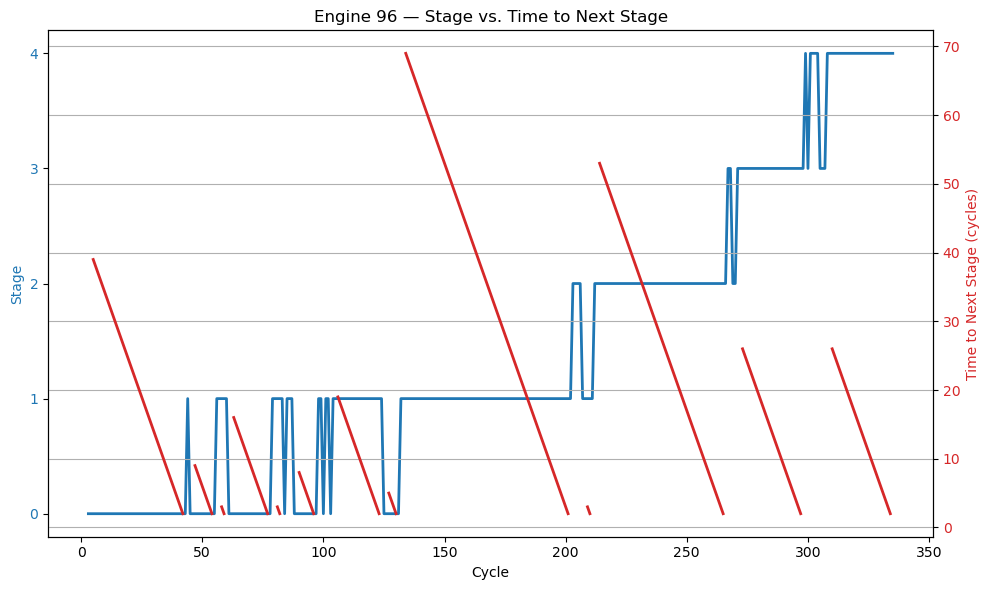

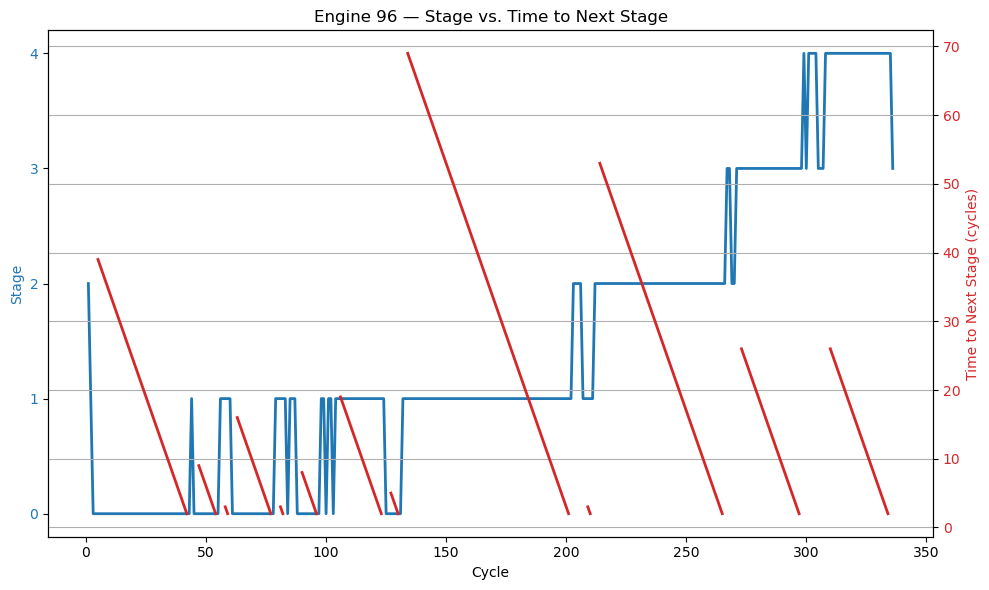

In [62]:
plot_time_to_next_stage(temp_df, 96)
plot_time_to_next_stage(df_clean, 96)

In [12]:
# Split into train-test
train_df = df[df["Engine no"] <= 80]
test_df = df[df["Engine no"] > 80]
train_df.shape, test_df.shape

((16137, 27), (4493, 27))

In [13]:
train_df.head()

,Engine no,Num cycles,Operating 1,Operating 2,Operating 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,Sensor 10,Sensor 11,Sensor 12,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Stage
0,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,0
1,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,0
2,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,0
3,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,0
4,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,21.61,554.67,2388.02,9049.68,1.3,47.16,521.68,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669,0


In [14]:
test_df.head()

,Engine no,Num cycles,Operating 1,Operating 2,Operating 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,Sensor 10,Sensor 11,Sensor 12,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Stage
16137,81,1,-0.0050,0.0003,100.0,518.67,642.04,1589.91,1406.63,14.62,21.61,553.78,2388.10,9060.49,1.3,47.53,522.09,2388.04,8134.78,8.4455,0.03,391,2388,100.0,38.87,23.3365,3
16138,81,2,0.0023,0.0002,100.0,518.67,642.65,1586.25,1407.88,14.62,21.61,553.70,2388.09,9064.32,1.3,47.39,522.07,2388.07,8140.37,8.4573,0.03,392,2388,100.0,38.91,23.3452,2
16139,81,3,-0.0005,0.0005,100.0,518.67,642.55,1586.42,1396.40,14.62,21.61,553.28,2388.11,9058.66,1.3,47.39,521.07,2388.06,8139.75,8.4522,0.03,394,2388,100.0,39.04,23.3610,1
16140,81,4,-0.0001,-0.0000,100.0,518.67,642.41,1594.89,1404.86,14.62,21.61,554.25,2388.04,9056.54,1.3,47.59,521.68,2388.04,8144.12,8.4403,0.03,392,2388,100.0,38.77,23.4206,1
16141,81,5,0.0024,0.0002,100.0,518.67,643.41,1590.49,1409.58,14.62,21.61,553.50,2388.04,9058.47,1.3,47.24,521.47,2388.12,8139.21,8.3971,0.03,392,2388,100.0,39.04,23.3311,1
